In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from skimage.io import imread
import os
import time
import datetime
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from sklearn.manifold import TSNE

### Build dataloader

In [67]:
class MyoDataSet(Dataset):
    def __init__(self, folder, mode, len_in, normalization=1000):     # Images are placed under a single folder; first image name is treatment type
        super().__init__()

        if mode=='Train':
            fpath = folder+'/Train'
        elif mode=='Test':
            fpath = folder+'/Test'
        else:
            raise ValueError
        
        fileList = os.listdir(fpath)       # find all images in folder
        self.image_stacks = []
        self.image_size = []
        self.label_list = []
        for ii in range(len(fileList)):
            file = fpath+'/'+fileList[ii]
            im = imread(file).astype('float32')
            self.image_stacks += [torch.Tensor(im)/normalization]#/torch.Tensor(im).max()]
            self.image_size += [im.shape[0]]
            self.label_list += [fileList[ii].split('_')[0]]
        
        self.len_in = len_in
        
    def __len__(self):
        numMovie = len(self.label_list)
        return np.sum(self.image_size) - numMovie * (self.len_in-1)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        eff_img_size = np.array(self.image_size) - (self.len_in - 1)
        cum_img_size = np.cumsum(eff_img_size)
        image_id = np.sum(idx>=cum_img_size)
        stack_id = idx if image_id==0 else idx-cum_img_size[image_id-1]

        image_stack = self.image_stacks[image_id]
        x = {'input': image_stack[stack_id:stack_id+self.len_in], 'target': image_stack[stack_id:stack_id+self.len_in], 'label': self.label_list[image_id]}

        return x
    
    def get_loader(self, indices, batch_size, num_workers, pin_memory=True):
        sampler = SubsetRandomSampler(indices)
        loader = torch.utils.data.DataLoader(self, 
            batch_size=batch_size,
            num_workers=num_workers, # number of cores to use, I usually just choose either 0 or 4
            sampler=sampler, 
            pin_memory=pin_memory) # pin memory should be true if you are transferring data between cpu and gpu
        return loader

In [59]:
class MyoDataSet(Dataset):
    def __init__(self, image_stack, len_in, normalization=1000):
        super().__init__()

        self.data = torch.tensor(image_stack)/normalization
        self.len_in = len_in

    def __len__(self):
        return len(self.data)-self.len_in+1

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        x = {'input': self.data[idx:idx+self.len_in], 
             'target': self.data[idx:idx+self.len_in]}
        
        return x

    def get_loader(self, indices, batch_size, num_workers, pin_memory=True):
        sampler = SubsetRandomSampler(indices)
        loader = torch.utils.data.DataLoader(self, 
            batch_size=batch_size,
            num_workers=num_workers, # number of cores to use, I usually just choose either 0 or 4
            sampler=sampler, 
            pin_memory=pin_memory) # pin memory should be true if you are transferring data between cpu and gpu
        return loader



In [95]:
#im1 = imread('./data/Train/JLY_cell1_cutout1.tif').astype('float32')
trainSet = MyoDataSet('./data/', 'Train', 6)
testSet = MyoDataSet('./data', 'Test', 6)
#print('There are', len(trainSet), 'images in the training set and', len(testSet), 'images in the test set.')

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


In [58]:
torch.tensor(im1).max()

tensor(3882.)

tensor(2.0440)


TypeError: Invalid shape (6, 128, 128) for image data

<Figure size 432x576 with 0 Axes>

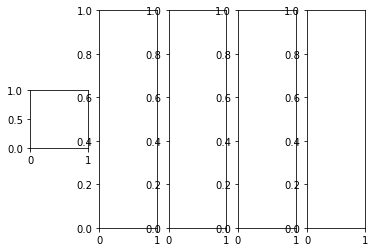

In [96]:
ct = 0
plt.figure(figsize=(6,8))
fig, ax = plt.subplots(1, 5)
for id in np.random.randint(len(trainSet), size = 5):
    x = trainSet[id]
    print(x['input'].max())
    ax[ct].imshow(x['input'].squeeze())
    ct += 1

In [12]:
print(trainSet[80]['label'])

WT


In [97]:
train_loader = trainSet.get_loader(np.arange(len(trainSet)), 10, 0)
x = next(iter(train_loader))
print(x['target'][0,:].max())
#for thisbatch in train_loader:
#    print(thisbatch['input'].shape)
print(len(train_loader))

tensor(1.4940)
9


### Define convolutional autoencoder

In [77]:
class encoderNN(nn.Module):
    def __init__(self, input_size=(1, 128, 128), fmap_inc_factor = 2, layers=3, downsample_factor=2, neck_dim=100):
        super().__init__()

        in_channel, h, w = tuple(input_size)
        current_size = (h, w)

        # List of encoder layers
        encoderList = []
        current_fmaps = in_channel
        for ii in range(layers):
            out_fmap = current_fmaps * fmap_inc_factor
            encoderList += [nn.Conv2d(current_fmaps, out_fmap, kernel_size=(3,3), padding=1),
                         #nn.BatchNorm2d(out_fmap),
                         nn.ReLU(),
                         nn.MaxPool2d((downsample_factor, downsample_factor))]
            current_fmaps = out_fmap
            h = int(h/downsample_factor)
            w = int(w/downsample_factor)
        
        self.encoder = nn.Sequential(*encoderList)
        self.bottom_h = h
        self.bottom_w = w

        # List of bottleneck layers
        #dense1 = current_fmaps*h*w
        #neckList = [nn.Flatten(),
        #            nn.Linear(dense1, neck_dim),
        #            nn.ReLU(),
        #            nn.Dropout()]

        #self.bottleneck = nn.Sequential(*neckList)

    def forward(self, x):
        x = self.encoder(x)
        #x = self.bottleneck(x)
        return x

class interp(nn.Module):
    def __init__(self, size, mode='nearest-exact'):
        super().__init__()

        self.size = size
        self.mode = mode

    def forward(self, x):
        return nn.functional.interpolate(x, size = self.size, mode = self.mode)

class decoderNN(nn.Module):
    def __init__(self, output_size=(1, 128, 128), fmap_dec_factor = 2, layers=3, upsample_factor=2, neck_dim=100):
        super().__init__()

        target_fmaps, h, w = tuple(output_size)
        self.bottom_h = int(h * upsample_factor**(-layers))
        self.bottom_w = int(w * upsample_factor**(-layers))
        self.in_channel = int(target_fmaps * np.power(fmap_dec_factor, layers))

        dense1 = self.in_channel * self.bottom_h * self.bottom_w

        #self.upNeck = nn.Sequential(nn.Linear(neck_dim, dense1), nn.ReLU(), nn.Dropout())

        decoderList = []

        current_fmaps = self.in_channel       # Try interpolate+convolution instead of ConvTranspose2d to avoid checkerboard artifect?
        #(h, w) = (self.bottom_h*upsample_factor, self.bottom_w*upsample_factor)
        for ii in range(layers-1):
            out_fmaps = int(current_fmaps / fmap_dec_factor)
            decoderList += [nn.ConvTranspose2d(current_fmaps, out_fmaps, kernel_size = (4,4), stride = upsample_factor, padding = 1), 
                            nn.BatchNorm2d(out_fmaps),
                            nn.ReLU()] #interp((h, w), 'nearest-exact'), nn.Conv2d(current_fmaps, out_fmaps, kernel_size=(3,3), padding=1),
            current_fmaps = out_fmaps
            #(h, w) = (h*upsample_factor, w*upsample_factor)
         
        decoderList += [nn.ConvTranspose2d(current_fmaps, target_fmaps, kernel_size = (4,4), stride = upsample_factor, padding = 1)] #interp((h, w), 'nearest-exact'), nn.Conv2d(current_fmaps, target_fmaps, kernel_size=(3,3), padding=1)
                        #nn.BatchNorm2d(target_fmaps),
                        #nn.Sigmoid()]
                        
        self.decoder = nn.Sequential(*decoderList)

    def forward(self, x):
        #x = self.upNeck(x)
        #x = x.view(-1, self.in_channel, self.bottom_h, self.bottom_w)
        x = self.decoder(x)
        return x


class CAE(nn.Module):
    def __init__(self, input_size = (1, 128, 128), fmap_inc_factor = 2, layers = 3, sample_factor = 2, neckdim = 100):
        super().__init__()
        self.input_size = input_size
        self.fmap_inc_factor = fmap_inc_factor
        self.layers = layers
        self.sample_factor = sample_factor
        self.neckdim = neckdim

        self.encoding = encoderNN(self.input_size, self.fmap_inc_factor, self.layers, self.sample_factor, self.neckdim)
        self.decoding = decoderNN(self.input_size, self.fmap_inc_factor, self.layers, self.sample_factor, self.neckdim)
        
    def forward(self, x):
        encoded = self.encoding(x)
        decoded = self.decoding(encoded)
        return decoded

In [98]:
# Print model summary
input_size = (6, 128, 128)
fmap_inc_factor = 2
layers = 3
sample_factor = 2
neckdim = 100
model_3l = CAE(input_size, fmap_inc_factor, layers, sample_factor, neckdim)
summary(model_3l, input_size=(10, 6, 128, 128))       # Input size for torchinfo needs to have the size (B,C,H,W)

Layer (type:depth-idx)                   Output Shape              Param #
CAE                                      [10, 6, 128, 128]         --
├─encoderNN: 1-1                         [10, 48, 16, 16]          --
│    └─Sequential: 2-1                   [10, 48, 16, 16]          --
│    │    └─Conv2d: 3-1                  [10, 12, 128, 128]        660
│    │    └─ReLU: 3-2                    [10, 12, 128, 128]        --
│    │    └─MaxPool2d: 3-3               [10, 12, 64, 64]          --
│    │    └─Conv2d: 3-4                  [10, 24, 64, 64]          2,616
│    │    └─ReLU: 3-5                    [10, 24, 64, 64]          --
│    │    └─MaxPool2d: 3-6               [10, 24, 32, 32]          --
│    │    └─Conv2d: 3-7                  [10, 48, 32, 32]          10,416
│    │    └─ReLU: 3-8                    [10, 48, 32, 32]          --
│    │    └─MaxPool2d: 3-9               [10, 48, 16, 16]          --
├─decoderNN: 1-2                         [10, 6, 128, 128]         --
│    └─

### Define model training/validation

In [148]:
if not os.path.exists('./logs'):
    os.mkdir('./logs')
%load_ext tensorboard
%tensorboard --logdir ./logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [11]:
## To do: move to device, metric for validation? training rate scheduler?

def train(model, dataloader, lossfn, optimizer, epochNum, tb_logger, device=None):     # Training step for each epoch
    if device is None:
        # You can pass in a device or we will default to using
        # the gpu. Feel free to try training on the cpu to see
        # what sort of performance difference there is
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.train()

    totalLoss = 0
    optimizer.zero_grad()
    for minibatch in dataloader:
        y = model(minibatch['input'])
        loss = lossfn(y, minibatch['target'])
        loss.backward()
        optimizer.step()
        totalLoss += loss

    if tb_logger is not None:
        tb_logger.add_scalar(tag="train_loss", scalar_value=totalLoss.item(), global_step=epochNum)

    return totalLoss/len(dataloader)

def validate(model, dataloader, lossfn, epochNum, tb_logger, device=None):      # Validate after each epoch, returns the loss 
    if device is None:
        # You can pass in a device or we will default to using
        # the gpu. Feel free to try training on the cpu to see
        # what sort of performance difference there is
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.eval()

    x = next(iter(dataloader))
    y = model(x['input'])
    loss = lossfn(y, x['target'])

    if tb_logger is not None:
        tb_logger.add_scalar(tag="val_loss", scalar_value=loss.item(), global_step=epochNum)

    return loss

In [99]:
loss = torch.nn.MSELoss()
optim = torch.optim.Adam(params = model_3l.parameters(), lr = 1e-4)
#timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d-%H:%M:%S')
logger = None #SummaryWriter('./logs/test2')

numEpoch = 500
train_loss = np.zeros(numEpoch)
val_loss = np.zeros(numEpoch)
for ii in tqdm(range(numEpoch)):
    epochLoss = train(model_3l, train_loader, loss, optim, ii, logger)
    validLoss = validate(model_3l, train_loader, loss, ii, logger)
    train_loss[ii] = epochLoss
    val_loss[ii] = validLoss
    if ii%50==1:
        print("Epoch", ii, "  Training loss:", epochLoss.detach().cpu().numpy(), ",  Validation loss:", validLoss.detach().cpu().numpy())

#torch.save(model_3l.state_dict(), 'mixed_input_noneck_3layer_MSE.pt')
    

  0%|          | 2/500 [00:01<05:01,  1.65it/s]

Epoch 1   Training loss: 0.2753289 ,  Validation loss: 0.35724276


 10%|█         | 52/500 [00:30<04:36,  1.62it/s]

Epoch 51   Training loss: 0.04426692 ,  Validation loss: 0.04991754


 20%|██        | 102/500 [01:02<04:52,  1.36it/s]

Epoch 101   Training loss: 0.031887095 ,  Validation loss: 0.047056276


 30%|███       | 152/500 [01:37<04:05,  1.42it/s]

Epoch 151   Training loss: 0.029621694 ,  Validation loss: 0.009943848


 40%|████      | 202/500 [02:09<03:02,  1.63it/s]

Epoch 201   Training loss: 0.025580514 ,  Validation loss: 0.04081281


 50%|█████     | 252/500 [02:38<02:20,  1.76it/s]

Epoch 251   Training loss: 0.027715674 ,  Validation loss: 0.018059332


 60%|██████    | 302/500 [03:07<01:55,  1.72it/s]

Epoch 301   Training loss: 0.023164434 ,  Validation loss: 0.022245487


 70%|███████   | 352/500 [03:36<01:24,  1.76it/s]

Epoch 351   Training loss: 0.024026893 ,  Validation loss: 0.030375835


 80%|████████  | 402/500 [04:04<00:55,  1.75it/s]

Epoch 401   Training loss: 0.018904649 ,  Validation loss: 0.023567902


 90%|█████████ | 452/500 [04:33<00:27,  1.73it/s]

Epoch 451   Training loss: 0.021446332 ,  Validation loss: 0.022632929


100%|██████████| 500/500 [05:00<00:00,  1.66it/s]


### Examine model output

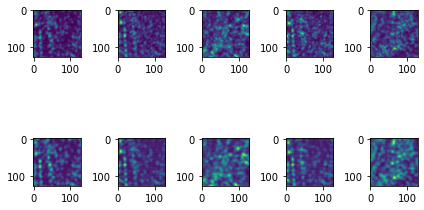

In [100]:
model_3l.eval()

fig, ax = plt.subplots(2, 5)
ct = 0
batch = next(iter(train_loader))
x = batch['input']
y = batch['target']
pred = model_3l(x)
for jj in range(5):
    ax[0][ct].imshow(y[jj, 1, ...].squeeze().detach().cpu().numpy())
    ax[1][ct].imshow(pred[jj, 1, ...].squeeze().detach().cpu().numpy())
    ct += 1

plt.tight_layout()
#plt.savefig('trainSet_targ_pred_mixed_input_noneck_3layer_MSE.png')

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


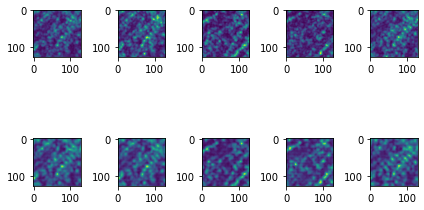

In [103]:
model_3l.eval()
testSet = MyoDataSet('./data', 'Test', 6)
testloader = testSet.get_loader(np.arange(len(testSet)), 5, 0)

fig, ax = plt.subplots(2, 5)
ct = 0
batch = next(iter(testloader))
x = batch['input']
y = batch['target']
pred = model_3l(x)
for jj in range(len(x)):
    ax[0][ct].imshow(y[jj, 0, ...].squeeze().detach().cpu().numpy())
    ax[1][ct].imshow(pred[jj, 0, ...].squeeze().detach().cpu().numpy())
    ct += 1

plt.tight_layout()
#plt.savefig('testSet_targ_pred_mixed_input_neck100_3layer_MSE.png')

### T-SNE of bottleneck

['WT', 'WT', 'JLY', 'JLY', 'WT', 'JLY', 'JLY', 'JLY', 'WT', 'WT', 'JLY', 'JLY', 'WT', 'JLY', 'JLY', 'JLY', 'JLY', 'JLY', 'JLY', 'JLY', 'WT', 'WT', 'JLY', 'WT', 'WT', 'JLY', 'WT', 'JLY', 'JLY', 'JLY', 'JLY', 'WT', 'JLY', 'JLY', 'WT', 'WT', 'WT', 'WT', 'JLY', 'WT', 'WT', 'JLY', 'JLY', 'WT', 'JLY', 'WT', 'JLY', 'WT', 'JLY', 'JLY', 'JLY', 'JLY', 'WT', 'JLY', 'WT', 'JLY', 'WT', 'WT', 'JLY', 'WT', 'JLY', 'WT', 'JLY', 'WT', 'JLY', 'JLY', 'JLY', 'JLY', 'WT', 'JLY', 'JLY', 'WT', 'JLY', 'JLY', 'WT', 'JLY', 'JLY', 'JLY', 'JLY', 'JLY', 'WT', 'WT', 'JLY', 'JLY', 'WT', 'WT', 'JLY', 'JLY', 'WT']
(89, 2)
(array([ 2,  3,  5,  6,  7, 10, 11, 13, 14, 15, 16, 17, 18, 19, 22, 25, 27,
       28, 29, 30, 32, 33, 38, 41, 42, 44, 46, 48, 49, 50, 51, 53, 55, 58,
       60, 62, 64, 65, 66, 67, 69, 70, 72, 73, 75, 76, 77, 78, 79, 82, 83,
       86, 87], dtype=int64),)


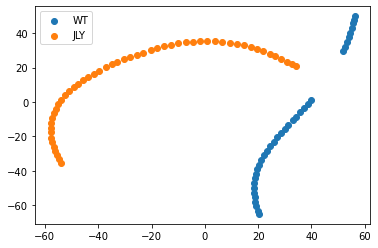

In [111]:
model_3l.eval()
test_loader = testSet.get_loader(np.arange(len(trainSet)), 99, 0)
X_in = next(iter(test_loader))
print(X_in['label'])
X = model_3l.encoding(X_in['input']).detach()
X = torch.flatten(X, start_dim = 1)
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X)
print(X_embedded.shape)
groups = ['WT', 'JLY']
print(np.where(np.array(X_in['label'])=='JLY'))
for g in groups:
    idx = np.where(np.array(X_in['label'])==g)
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=g)
plt.legend()
# Plot bottleneck layers
#fig, ax = plt.subplots(1, 4)
#for jj in range(len(x)):
#    ax[jj].imshow(X[jj, 3, ...].squeeze().detach().cpu().numpy())